# Lookup Citation Trend with Scholarly

This is a demo of how to use the Scholarly API to lookup citations for a keyword. The example is to look up a well-cited, or even well-mentioned phrase over time and get the number of citations per year.

In [1]:
# import the scholarly library and the ProxyGenerator class
from scholarly import scholarly
from scholarly import ProxyGenerator

# use ScraperAPI proxy with the API key from .secrets SCRAPERAPI_KEY variable.
## first read the .secrets file and get the SCRAPERAPI_KEY
with open('.secrets', 'r') as file:
    for line in file:
        if 'SCRAPERAPI_KEY' in line:
            SCRAPERAPI_KEY = line.split('=')[1].strip()
            break

# create a proxy generator
pg = ProxyGenerator()
pg.ScraperAPI(SCRAPERAPI_KEY)

True

In [3]:
# keyword lookup with scholarly

# import the scholarly library
from scholarly import scholarly

# search for a well-cited phrase
query = 'LabstreamingLayer'
year_low = 2010
year_high = 2025
search_query = scholarly.search_pubs(query, year_low=year_low, year_high=year_high)

# print the first result
print(f"Total results for {query}: {search_query.total_results}")

Total results for LabstreamingLayer: 2340


In [4]:
# Now let's get the number of citations for each year

citecount = {}
for year in range(year_low, year_high + 1):
    print(f"Getting citations for {year}")
    search_query = scholarly.search_pubs(query, year_low=year, year_high=year)
    citecount[year] = search_query.total_results
    print(f"Citations for {year}: {citecount[year]}")

Getting citations for 2010
Citations for 2010: 0
Getting citations for 2011
Citations for 2011: 0
Getting citations for 2012
Citations for 2012: 3
Getting citations for 2013
Citations for 2013: 9
Getting citations for 2014
Citations for 2014: 20
Getting citations for 2015
Citations for 2015: 18
Getting citations for 2016
Citations for 2016: 43
Getting citations for 2017
Citations for 2017: 73
Getting citations for 2018
Citations for 2018: 102
Getting citations for 2019
Citations for 2019: 182
Getting citations for 2020
Citations for 2020: 182
Getting citations for 2021
Citations for 2021: 293
Getting citations for 2022
Citations for 2022: 289
Getting citations for 2023
Citations for 2023: 394
Getting citations for 2024
Citations for 2024: 490
Getting citations for 2025
Citations for 2025: 236


Data points: 15 (years 2010-2024)
Total citations: 2098

POLYNOMIAL MODEL SELECTION ANALYSIS

Degree 1:
  R² = 0.8554, Adj-R² = 0.8313
  AIC = 126.1, BIC = 127.5
  CV-MSE = 11158.4

Degree 2:
  R² = 0.9875, Adj-R² = 0.9841
  AIC = 91.4, BIC = 93.5
  CV-MSE = 539.4

Degree 3:
  R² = 0.9885, Adj-R² = 0.9839
  AIC = 92.1, BIC = 95.0
  CV-MSE = 2118.1

Degree 4:
  R² = 0.9885, Adj-R² = 0.9821
  AIC = 94.1, BIC = 97.7
  CV-MSE = 2124.4

Degree 5:
  R² = 0.9885, Adj-R² = 0.9799
  AIC = 96.1, BIC = 100.4
  CV-MSE = 2130.6

Degree 6:
  R² = 0.9885, Adj-R² = 0.9770
  AIC = 98.1, BIC = 103.1
  CV-MSE = 2136.8

--------------------------------------------------
F-TESTS FOR MODEL COMPARISON:
--------------------------------------------------
Degree 1 vs 2: F = 127.09, p = 0.0000 ***
Degree 2 vs 3: F = 0.93, p = 0.3544 
Degree 3 vs 4: F = 0.00, p = 0.9975 
Degree 4 vs 5: F = 0.00, p = 0.9976 
Degree 5 vs 6: F = 0.00, p = 0.9977 

MODEL SELECTION RESULTS:
Best R²:     Degree 6 (R² = 0.9885)
Best Adj

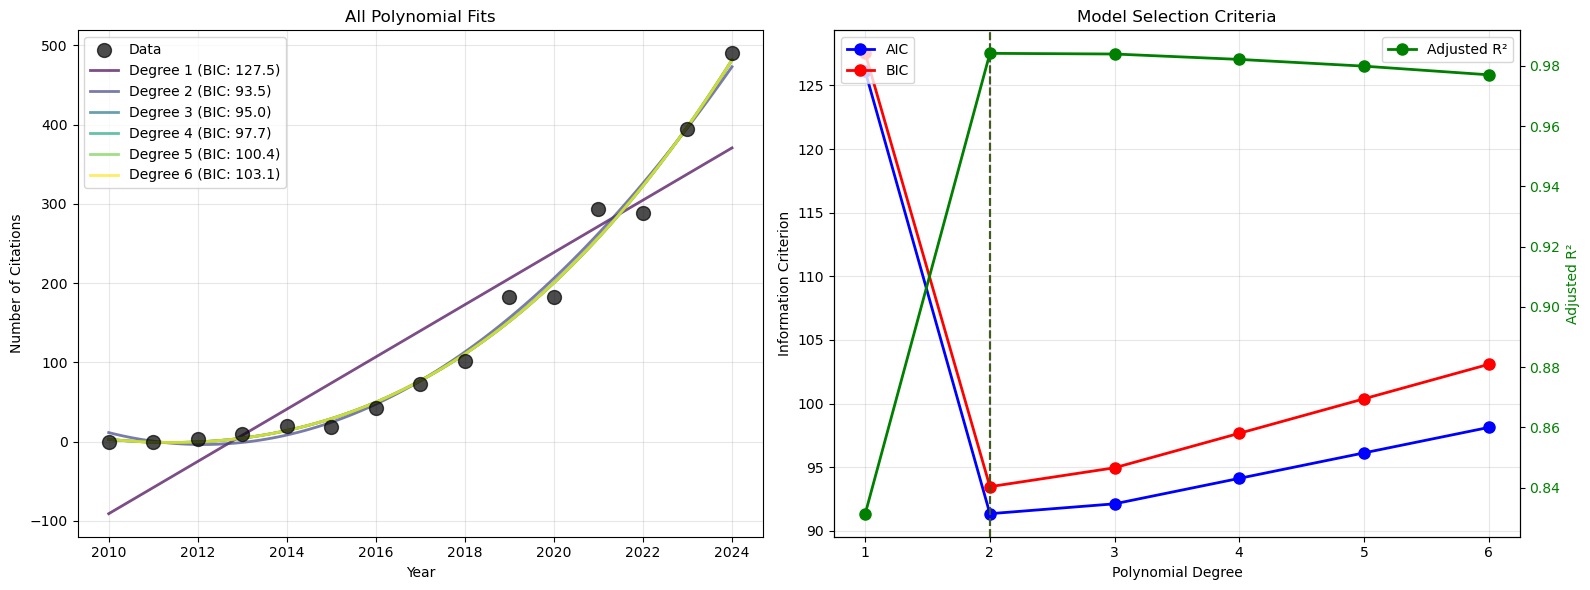

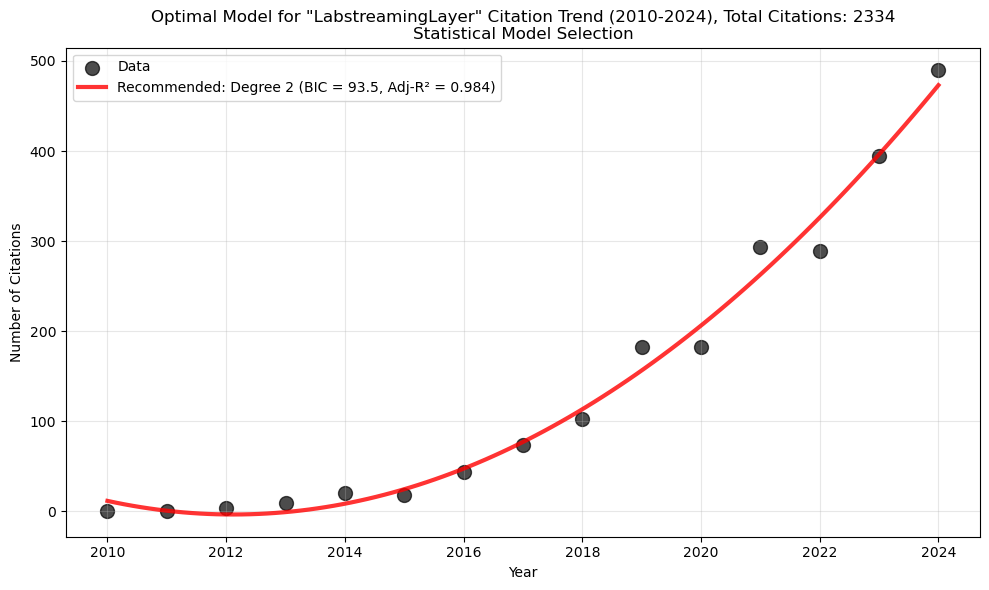

In [11]:
# Polynomial Model Selection with Statistical Criteria
# Similar to MATLAB's stepwisefit - finds optimal complexity with proper penalties
# Exclude 2025 since the year is not complete yet

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Filter out 2025 data
filtered_citecount = {year: count for year, count in citecount.items() if year != 2025}

# Extract years and citations for plotting
years = np.array(list(filtered_citecount.keys())).reshape(-1, 1)
citations = np.array(list(filtered_citecount.values()))

print(f"Data points: {len(years)} (years {years.min().item()}-{years.max().item()})")
print(f"Total citations: {citations.sum()}")

# Model selection with multiple criteria
def evaluate_polynomial(degree, X, y):
    """Evaluate polynomial model with multiple criteria"""
    n = len(y)
    
    # Fit polynomial
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('linear', LinearRegression())
    ])
    
    poly_model.fit(X, y)
    y_pred = poly_model.predict(X)
    
    # Calculate metrics
    mse = np.mean((y - y_pred)**2)
    r2 = r2_score(y, y_pred)
    
    # Adjusted R-squared (penalizes for additional parameters)
    k = degree + 1  # number of parameters
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    
    # Information criteria
    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + np.log(n) * k  # BIC has stronger penalty
    
    # Cross-validation score (if we have enough data)
    cv_score = np.nan
    if n > 5:  # Only do CV if we have enough points
        try:
            cv_scores = cross_val_score(poly_model, X, y, cv=min(5, n-1), 
                                      scoring='neg_mean_squared_error')
            cv_score = -cv_scores.mean()
        except:
            cv_score = np.nan
    
    return {
        'degree': degree,
        'model': poly_model,
        'mse': mse,
        'r2': r2,
        'adj_r2': adj_r2,
        'aic': aic,
        'bic': bic,
        'cv_mse': cv_score,
        'params': k
    }

def f_test_nested_models(model1, model2, X, y):
    """F-test to compare nested models (model2 should have more parameters)"""
    if model1['params'] >= model2['params']:
        return np.nan, np.nan
    
    n = len(y)
    rss1 = model1['mse'] * n  # Residual sum of squares
    rss2 = model2['mse'] * n
    
    p1, p2 = model1['params'], model2['params']
    
    # F-statistic
    f_stat = ((rss1 - rss2) / (p2 - p1)) / (rss2 / (n - p2))
    p_value = 1 - stats.f.cdf(f_stat, p2 - p1, n - p2)
    
    return f_stat, p_value

# Test polynomial degrees 1 through 6
max_degree = min(6, len(years) - 2)  # Don't overfit with small data
results = []

print("\n" + "="*80)
print("POLYNOMIAL MODEL SELECTION ANALYSIS")
print("="*80)

for degree in range(1, max_degree + 1):
    result = evaluate_polynomial(degree, years, citations)
    results.append(result)
    
    print(f"\nDegree {degree}:")
    print(f"  R² = {result['r2']:.4f}, Adj-R² = {result['adj_r2']:.4f}")
    print(f"  AIC = {result['aic']:.1f}, BIC = {result['bic']:.1f}")
    if not np.isnan(result['cv_mse']):
        print(f"  CV-MSE = {result['cv_mse']:.1f}")

# Statistical significance testing (F-tests for nested models)
print("\n" + "-"*50)
print("F-TESTS FOR MODEL COMPARISON:")
print("-"*50)

for i in range(len(results)-1):
    f_stat, p_val = f_test_nested_models(results[i], results[i+1], years, citations)
    if not np.isnan(f_stat):
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"Degree {i+1} vs {i+2}: F = {f_stat:.2f}, p = {p_val:.4f} {significance}")

# Model selection based on different criteria
best_r2 = max(results, key=lambda x: x['r2'])
best_adj_r2 = max(results, key=lambda x: x['adj_r2'])
best_aic = min(results, key=lambda x: x['aic'])
best_bic = min(results, key=lambda x: x['bic'])

valid_cv = [r for r in results if not np.isnan(r['cv_mse'])]
best_cv = min(valid_cv, key=lambda x: x['cv_mse']) if valid_cv else None

print("\n" + "="*50)
print("MODEL SELECTION RESULTS:")
print("="*50)
print(f"Best R²:     Degree {best_r2['degree']} (R² = {best_r2['r2']:.4f})")
print(f"Best Adj-R²: Degree {best_adj_r2['degree']} (Adj-R² = {best_adj_r2['adj_r2']:.4f})")
print(f"Best AIC:    Degree {best_aic['degree']} (AIC = {best_aic['aic']:.1f})")
print(f"Best BIC:    Degree {best_bic['degree']} (BIC = {best_bic['bic']:.1f})")
if best_cv:
    print(f"Best CV:     Degree {best_cv['degree']} (CV-MSE = {best_cv['cv_mse']:.1f})")

# Choose the most conservative model (BIC typically best for small samples)
recommended_model = best_bic
print(f"\n🎯 RECOMMENDED MODEL: Degree {recommended_model['degree']} polynomial")
print(f"   Rationale: BIC provides good balance of fit and complexity penalty")

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All models
years_plot = years.flatten()
ax1.scatter(years_plot, citations, s=100, alpha=0.7, color='black', label='Data', zorder=5)

colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
x_smooth = np.linspace(years_plot.min(), years_plot.max(), 100).reshape(-1, 1)

for i, result in enumerate(results):
    y_smooth = result['model'].predict(x_smooth)
    ax1.plot(x_smooth, y_smooth, color=colors[i], linewidth=2, alpha=0.7,
            label=f'Degree {result["degree"]} (BIC: {result["bic"]:.1f})')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Citations')
ax1.set_title('All Polynomial Fits')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Model selection criteria
ax2_twin = ax2.twinx()

degrees = [r['degree'] for r in results]
aics = [r['aic'] for r in results]
bics = [r['bic'] for r in results]
adj_r2s = [r['adj_r2'] for r in results]

ax2.plot(degrees, aics, 'bo-', label='AIC', linewidth=2, markersize=8)
ax2.plot(degrees, bics, 'ro-', label='BIC', linewidth=2, markersize=8)
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('Information Criterion', color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax2_twin.plot(degrees, adj_r2s, 'go-', label='Adjusted R²', linewidth=2, markersize=8)
ax2_twin.set_ylabel('Adjusted R²', color='green')
ax2_twin.tick_params(axis='y', labelcolor='green')

# Mark the best models
ax2.axvline(best_aic['degree'], color='blue', linestyle='--', alpha=0.7)
ax2.axvline(best_bic['degree'], color='red', linestyle='--', alpha=0.7)
ax2_twin.axvline(best_adj_r2['degree'], color='green', linestyle='--', alpha=0.7)

ax2.set_title('Model Selection Criteria')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final plot with recommended model
plt.figure(figsize=(10, 6))
plt.scatter(years_plot, citations, s=100, alpha=0.7, color='black', label='Data')

y_smooth = recommended_model['model'].predict(x_smooth)
plt.plot(x_smooth, y_smooth, color='red', linewidth=3, alpha=0.8,
         label=f'Recommended: Degree {recommended_model["degree"]} '
               f'(BIC = {recommended_model["bic"]:.1f}, Adj-R² = {recommended_model["adj_r2"]:.3f})')

plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.title(f'Optimal Model for "{query}" Citation Trend (2010-2024), Total Citations: {sum(citecount.values())}\n'
          f'Statistical Model Selection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()